In [1]:
# To do:
# 1. Train the model to data that has only been filtered manualy. (done)
# 2. Apply th model to data that has not already been filtered automaticly. (not done)
# 3. Plot the flags as seperate colors. i.e. Auto and Manual, Auto and Logmodel. (not done)

# This is actually just a plotting issue. 


This is the binary map for our pings  
bin is manualy chosen.  
pg is percent good.  
range is idk


b10 | binary | range | pg | bin |
----|--------|-------|----|-----|
0   | 000    |       |    |     |
1   | 001    |       |    |  X  | 
2   | 010    |       |  X |     |
3   | 011    |       |  X |   X |
4   | 100    |     X |    |     |
5   | 101    |     X |    |   X |
6   | 110    |     X |  X |     |
7   | 111    |     X |  X |   X |



In [2]:
from netCDF4 import Dataset
import numpy as np
from sklearn.linear_model import LogisticRegression 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pycurrents.codas import DB

In [3]:
### Load in the training data. 
dbname = "/home/jamie/cruise_processing/falkortoo/FKt240817/wh300/adcpdb/aship"
db = DB(dbname)
db.get_variable_names()
depth_train = db.get_variable('DEPTH')
amp_train = db.get_variable('AMP_SOUND_SCAT') # ie signal return
sw_train = db.get_variable('SPECTRAL_WIDTH') # ie correlation
pg_train = db.get_variable('PERCENT_GOOD')
mask_train = db.get_variable('PROFILE_FLAGS')
# error velocity sounds nice too

### Load in the test data. 
dbname = "/home/jamie/cruise_processing/falkortoo/FKt240224/wh300_patch/adcpdb/a_ftoo"
db = DB(dbname)
depth_test = db.get_variable('DEPTH')
amp_test = db.get_variable('AMP_SOUND_SCAT') # ie signal return
sw_test = db.get_variable('SPECTRAL_WIDTH') # ie correlation
pg_test = db.get_variable('PERCENT_GOOD')
mask_test = db.get_variable('PROFILE_FLAGS')
# error velocity sounds nice too

### Load in the test data u and v for plotting. 
file_id = Dataset('/home/jamie/cruise_processing/falkortoo/FKt240224/wh300_patch/contour/wh300.nc')
file_id.variables
v = file_id.variables["u"][:]
u = file_id.variables["v"][:]
file_id.close()

In [4]:
# I only want to run the model on data points that are either a 0 or a 1. 
# I will remove all point that are not 0 or 1. 
arg = [0, 1]# , 2, 3, 4, 5, 6, 7] #, 2, 6]
idx = np.isin(mask_train, arg)
# flatten the index and use that to index the row vectors
usr_mask = idx.flatten()
# flatten and subset. 
amp_train = amp_train.flatten()[usr_mask]
sw_train = sw_train.flatten()[usr_mask]
pg_train = pg_train.flatten()[usr_mask]
depth_train = depth_train.flatten()[usr_mask]
mask_train = mask_train.flatten()[usr_mask]

# Do the same above for the test data. 
# set all non-1 flags to one for model fitting and plotting. 
mask_train[mask_train != 0] = 1 

In [5]:
# in case I use anything other than arrg = [0,1]
# Tt's iportant that these are ordered correctly.  
train_cruise = np.stack([amp_train, depth_train, pg_train], axis=1) # pg_train, depth_train, sw_train, depth_train
test_cruise = np.stack([amp_test.flatten(), depth_test.flatten(), pg_test.flatten()], axis=1) # pg_test.flatten() sw.flatten(), depth_test.flatten(), sw_test.flatten()ugly...
y = mask_train

# run the model
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler.fit_transform(train_cruise)
X_train, X_test, y_train, y_test = train_test_split(train_cruise, y, test_size=0.7, random_state=42, stratify=y)
model = LogisticRegression(max_iter=7000)  
model.fit(X_train, y_train)

# apply to a new data set. 
new_y_pred = model.predict(test_cruise) 

# put humpoty dumpty back together again
n, m = mask_test.shape
flagged_array = new_y_pred.reshape(n, m) 

In [6]:
# Model Diagnostics. 
# y_pred = model.predict(X_test)
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print(classification_report(y_test, y_pred))

# np.unique(new_y_pred, return_counts=True)
# print("Min and Max of Scaled Features:", scaled_features.min(), scaled_features.max())
# y_pred = model.predict(X_test)
# print("Predicted class distribution:", np.unique(y_pred, return_counts=True))
# print("True class distribution:", np.unique(y_test, return_counts=True))

In [8]:
# Everything that isnt unflagged or manually flagged is now identified. 
auto_flagged = mask_test.copy()
bin_flag = mask_test.copy()

# subset only the algorithm falgs
arg = [0, 1]# , 2, 3, 4, 5, 6, 7] #, 2, 6]
idx = np.isin(mask_test, arg)
auto_flagged[~idx] = 1
auto_flagged[idx] = 0

# subset only the manualy edited falgs
arg = [1]# , 2, 3, 4, 5, 6, 7] #, 2, 6]
idx = np.isin(mask_test, arg)
bin_flag[~idx] = 0

# subset only the all the flags. 
all_flag = mask_test.copy()
all_flag[all_flag != 0] = 1

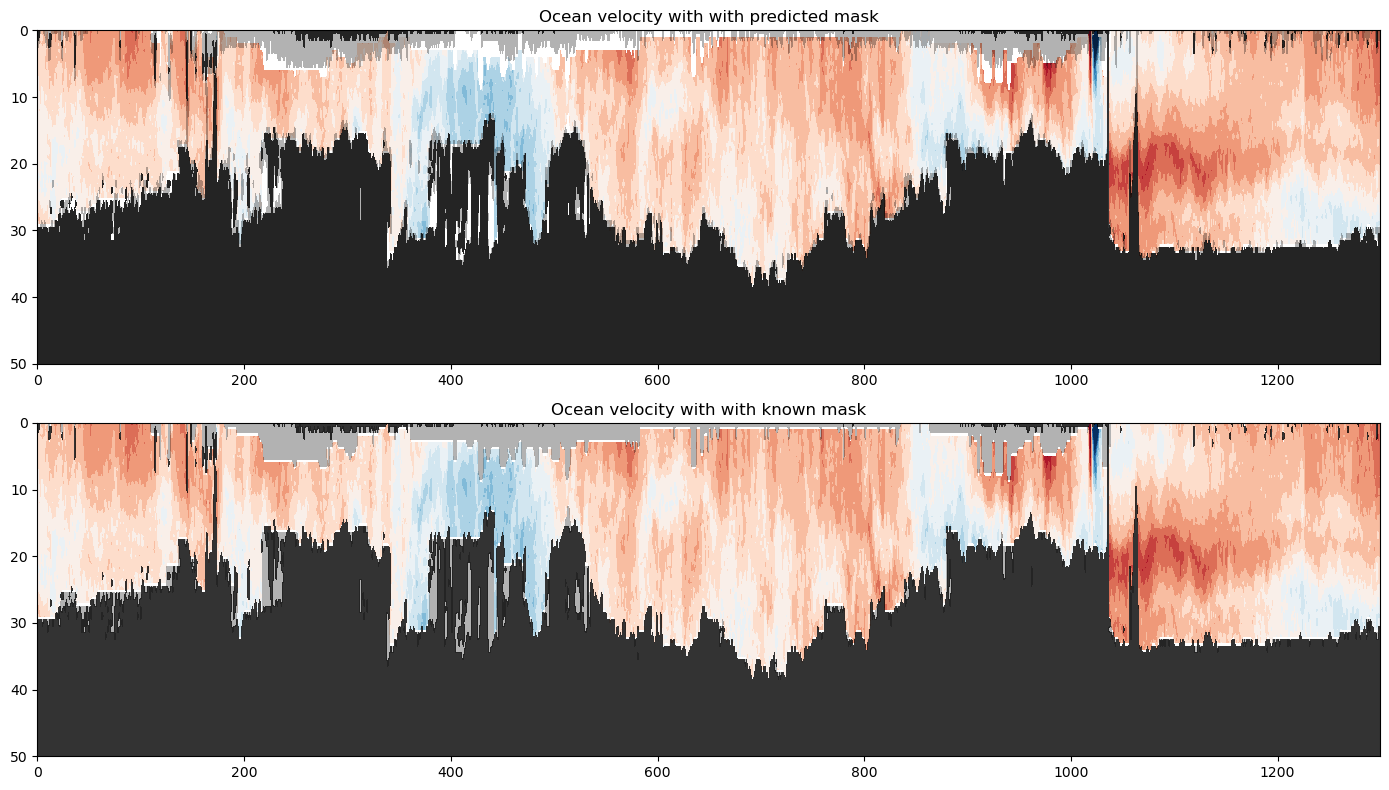

In [9]:
idx = range(3200, 4500)

# Define the feature array and predicted mask array
feature = u # n by m array
predicted_mask = flagged_array  # n by m array

fig, ax = plt.subplots(2, 1, figsize=(14, 8))
contour1 = ax[0].contourf(feature.T[:, idx], cmap='RdBu', levels=50)
contour1.set_clim(-0.4, 0.4)
# Overlay the predicted mask as a contour on top with transparency
ax[0].contourf(predicted_mask.T[:, idx], levels=[0.5, 1], colors='black', alpha=0.3)
ax[0].contourf(auto_flagged.T[:, idx], levels=[0.5, 1], colors='black', alpha=0.8)
ax[0].set_title('Ocean velocity with with predicted mask')
ax[0].set_ylim(50, 0)

contour2 = ax[1].contourf(feature.T[:, idx], cmap='RdBu',levels=50)
contour2.set_clim(-0.4, 0.4)
# Overlay the predicted mask as a contour on top with transparency
ax[1].contourf(bin_flag.T[:, idx], levels=[0.5, 1], colors='black', alpha=0.3)
ax[1].contourf(auto_flagged.T[:, idx], levels=[0.5, 1], colors='black', alpha=0.8)
ax[1].set_title('Ocean velocity with with known mask')
ax[1].set_ylim(50, 0)
# fig.colorbar(contour2, ax=ax, orientation='vertical', label="ocean velocity")
plt.tight_layout()
plt.show()

(58.0, 0.0)

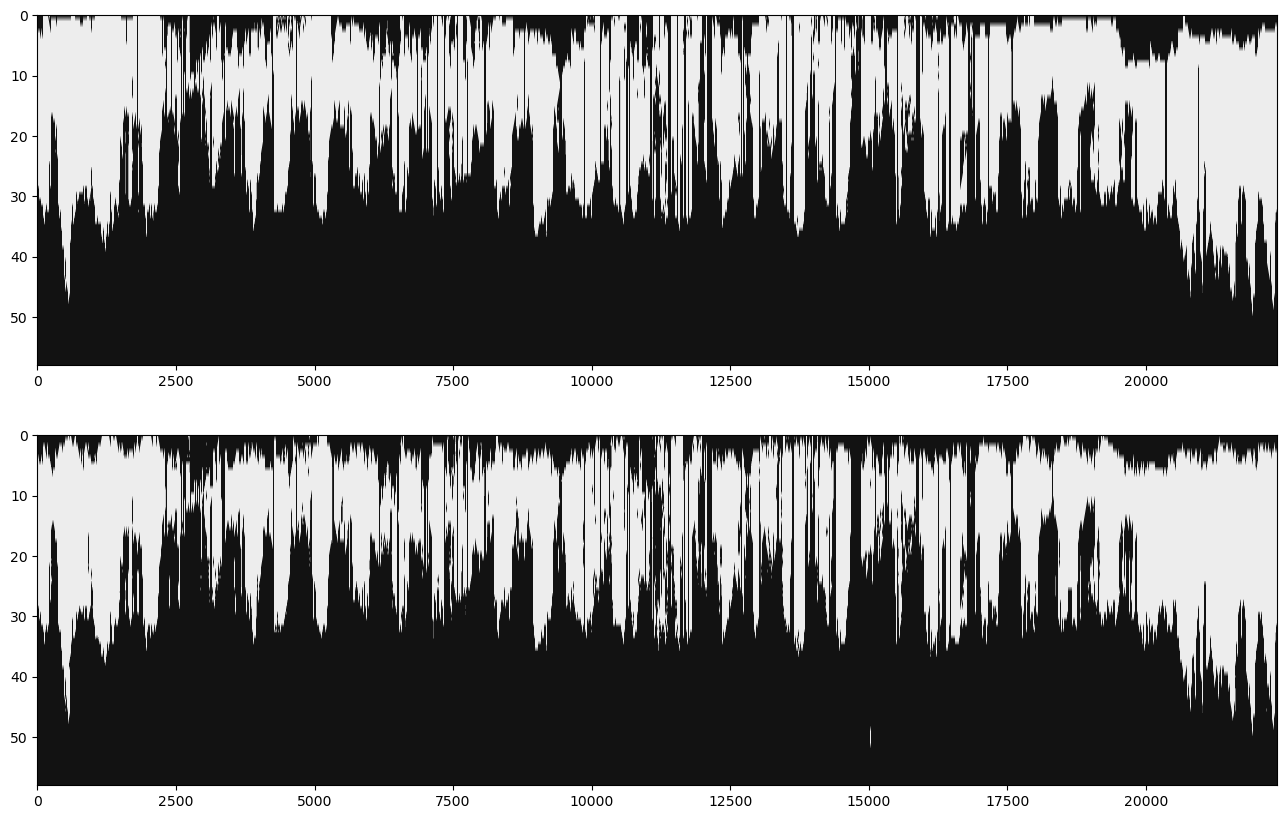

In [10]:
fig, ax = plt.subplots(2, 1, figsize = (16, 10))
ax[0].contourf(all_flag.T, cmap='binary') 
ax[0].set_ylim(58, 0)
ax[1].contourf(predicted_mask.T, cmap='binary') 
ax[1].set_ylim(58, 0)

In [11]:
# Land of lost code. 

# X is the feature array, and X.shape is (n_samples, n_features). 
# scaler = StandardScaler()
# scaled_features = scaler.fit_transform(X)
# scaled_y = y.reshape(-1,1)

# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler.fit_transform(X)

# The scalled features dont work nearly as well. This may be because percent good disporportanaly 
# is the driving factor for flagging. Or the signal is drowned out by the percent good. 

# put humpoty dumpty back together again
# tmp = np.empty((n,m,))
# tmp[:] = np.nan
# tmp = tmp.flatten()
# idx = np.where(usr_mask)
# idx = idx[0]
# for i in range(0, idx.shape[0]):
#     j = idx[i]
#     tmp[j] = new_y_pred[i]